In [ ]:
from pathlib import Path
import urllib.request
import tarfile
import torch
import torchaudio
from tqdm import tqdm
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def download_speech_commands(data_path="./speech_commands_data"):
    """
    Download and extract Google Speech Commands dataset v0.02

    Returns:
        bool: True if successful, False otherwise
    """
    data_path = Path(data_path)

    if data_path.exists() and any(data_path.iterdir()):
        print("✅ Dataset already exists")
        return True

    print("📥 Downloading Google Speech Commands dataset...")
    print("Dataset info: https://arxiv.org/abs/1804.03209")

    url = "https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz"
    tar_path = data_path.parent / "speech_commands_v0.02.tar.gz"

    try:
        # Create directory
        data_path.mkdir(parents=True, exist_ok=True)

        # Download with progress
        print(f"Downloading from: {url}")
        print("Size: ~2GB - this may take several minutes...")

        def progress_hook(block_num, block_size, total_size):
            downloaded = block_num * block_size
            if total_size > 0:
                percent = min(100, downloaded * 100 / total_size)
                print(f"\rDownload progress: {percent:.1f}%", end="", flush=True)

        urllib.request.urlretrieve(url, tar_path, reporthook=progress_hook)
        print("\n✅ Download complete")

        # Extract
        print("📦 Extracting dataset...")
        with tarfile.open(tar_path, "r:gz") as tar:
            tar.extractall(data_path)

        # Cleanup
        tar_path.unlink()
        print("✅ Dataset extraction complete")

        # Verify
        commands_found = [d.name for d in data_path.iterdir() if d.is_dir()]
        print(f"Found {len(commands_found)} command categories")

        return True

    except Exception as e:
        print(f"❌ Error downloading dataset: {e}")
        print("\nManual download instructions:")
        print(
            "1. Download: https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz"
        )
        print(f"2. Extract to: {data_path}")
        return False

# Run the download and extraction process.
download_speech_commands(data_path="./speech_commands_data")

📥 Downloading Google Speech Commands dataset...
Dataset info: https://arxiv.org/abs/1804.03209
Size: ~2GB - this may take several minutes...
Download progress: 100.0%
✅ Download complete
📦 Extracting dataset...
✅ Dataset extraction complete
Found 36 command categories


True

In [ ]:
# Define the 10 core commands
commands = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

# Define the data path
data_path = Path("./speech_commands_data")

# Read validation and testing lists
with open(data_path / 'validation_list.txt', 'r') as f:
    val_rel_paths = set(f.read().splitlines())
with open(data_path / 'testing_list.txt', 'r') as f:
    test_rel_paths = set(f.read().splitlines())

# Get all .wav files in the 10 command directories
all_files = []
for command in commands:
    command_dir = data_path / command
    wav_files = list(command_dir.glob('*.wav'))
    all_files.extend(wav_files)

# Assign files to train, val, test
train_files = []
val_files = []
test_files = []
for file in all_files:
    rel_path = str(file.relative_to(data_path))
    if rel_path in val_rel_paths:
        val_files.append(file)
    elif rel_path in test_rel_paths:
        test_files.append(file)
    else:
        train_files.append(file)

print(f"Number of training files: {len(train_files)}")
print(f"Number of validation files: {len(val_files)}")
print(f"Number of testing files: {len(test_files)}")

# Define label map
label_map = {command: i for i, command in enumerate(commands)}

Number of training files: 30769
Number of validation files: 3703
Number of testing files: 4074


In [ ]:
# Define MFCC transform
mfcc_transform = torchaudio.transforms.MFCC(
    sample_rate=16000,
    n_mfcc=20,
    melkwargs={'n_fft': 400, 'hop_length': 160, 'n_mels': 40}
)

# Function to compute MFCCs
def compute_mfccs(file_list, label_map, transform):
    mfccs = []
    labels = []
    max_len = 0

    # Compute all MFCCs and find the max sequence length
    for file in tqdm(file_list, desc="Computing MFCCs"):
        waveform, sr = torchaudio.load(file)
        if sr != 16000:
            print(f"Warning: sample rate {sr} for {file}")
        mfcc = transform(waveform).squeeze(0).transpose(0, 1)  # Shape: (seq_len, n_mfcc)
        max_len = max(max_len, mfcc.shape[0])
        mfccs.append(mfcc)
        labels.append(label_map[file.parent.name])

    # Pad all to max_len
    padded_mfccs = []
    for mfcc in mfccs:
        padded = F.pad(mfcc, (0, 0, 0, max_len - mfcc.shape[0]))
        padded_mfccs.append(padded)

    mfccs_tensor = torch.stack(padded_mfccs)  # Shape: (num_samples, seq_len, n_mfcc)
    labels_tensor = torch.tensor(labels)  # Shape: (num_samples,)
    return mfccs_tensor, labels_tensor

# Compute MFCCs for each split
train_mfccs, train_labels = compute_mfccs(train_files, label_map, mfcc_transform)
val_mfccs, val_labels = compute_mfccs(val_files, label_map, mfcc_transform)
test_mfccs, test_labels = compute_mfccs(test_files, label_map, mfcc_transform)

# Save to Google Drive
save_path = Path('/content/drive/MyDrive/speech_commands_mfccs')
save_path.mkdir(parents=True, exist_ok=True)
torch.save({'mfccs': train_mfccs, 'labels': train_labels}, save_path / 'train.pt')
torch.save({'mfccs': val_mfccs, 'labels': val_labels}, save_path / 'val.pt')
torch.save({'mfccs': test_mfccs, 'labels': test_labels}, save_path / 'test.pt')
print("MFCCs saved to Google Drive.")

Computing MFCCs: 100%|██████████| 4074/4074 [00:24<00:00, 168.77it/s]


MFCCs saved to Google Drive.


In [ ]:
# Load the precomputed MFCCs from Google Drive
save_path = '/content/drive/MyDrive/speech_commands_mfccs'
train_data = torch.load(f'{save_path}/train.pt')
val_data = torch.load(f'{save_path}/val.pt')
test_data = torch.load(f'{save_path}/test.pt')

train_mfccs, train_labels = train_data['mfccs'], train_data['labels']
val_mfccs, val_labels = val_data['mfccs'], val_data['labels']
test_mfccs, test_labels = test_data['mfccs'], test_data['labels']

print(f"Train MFCCs shape: {train_mfccs.shape}, Labels shape: {train_labels.shape}")
print(f"Val MFCCs shape: {val_mfccs.shape}, Labels shape: {val_labels.shape}")
print(f"Test MFCCs shape: {test_mfccs.shape}, Labels shape: {test_labels.shape}")

Train MFCCs shape: torch.Size([30769, 101, 20]), Labels shape: torch.Size([30769])
Val MFCCs shape: torch.Size([3703, 101, 20]), Labels shape: torch.Size([3703])
Test MFCCs shape: torch.Size([4074, 101, 20]), Labels shape: torch.Size([4074])


In [ ]:
# Prepare DataLoaders
batch_size = 64
train_dataset = TensorDataset(train_mfccs, train_labels)
val_dataset = TensorDataset(val_mfccs, val_labels)
test_dataset = TensorDataset(test_mfccs, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define the Vanilla RNN model
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(VanillaRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='relu', dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, hn = self.rnn(x)
        out = self.fc(hn[-1])
        return out

In [ ]:
# Initialize model and move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VanillaRNN(input_size=20, hidden_size=128, num_layers=3, output_size=10, dropout=0.25).to(device)

print(model)

VanillaRNN(
  (rnn): RNN(20, 128, num_layers=3, batch_first=True, dropout=0.25)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)


Epoch [1/200], Train Loss: 2.2150, Train Accuracy: 16.48%, Val Loss: 2.0609, Val Accuracy: 21.71%
Epoch [2/200], Train Loss: 2.0396, Train Accuracy: 22.93%, Val Loss: 2.1084, Val Accuracy: 17.96%
Epoch [3/200], Train Loss: 1.9822, Train Accuracy: 24.51%, Val Loss: 1.9098, Val Accuracy: 25.76%
Epoch [4/200], Train Loss: 1.9252, Train Accuracy: 26.19%, Val Loss: 1.8638, Val Accuracy: 27.14%
Epoch [5/200], Train Loss: 1.8279, Train Accuracy: 30.31%, Val Loss: 1.7448, Val Accuracy: 31.30%
Epoch [6/200], Train Loss: 1.7932, Train Accuracy: 32.65%, Val Loss: 1.8406, Val Accuracy: 35.84%
Epoch [7/200], Train Loss: 1.6927, Train Accuracy: 37.26%, Val Loss: 1.8090, Val Accuracy: 35.35%
Epoch [8/200], Train Loss: 1.6065, Train Accuracy: 41.28%, Val Loss: 1.5191, Val Accuracy: 44.13%
Epoch [9/200], Train Loss: 1.6055, Train Accuracy: 40.46%, Val Loss: 1.6806, Val Accuracy: 37.67%
Epoch [10/200], Train Loss: 1.5951, Train Accuracy: 40.57%, Val Loss: 1.4478, Val Accuracy: 44.48%
Epoch [11/200], Tra

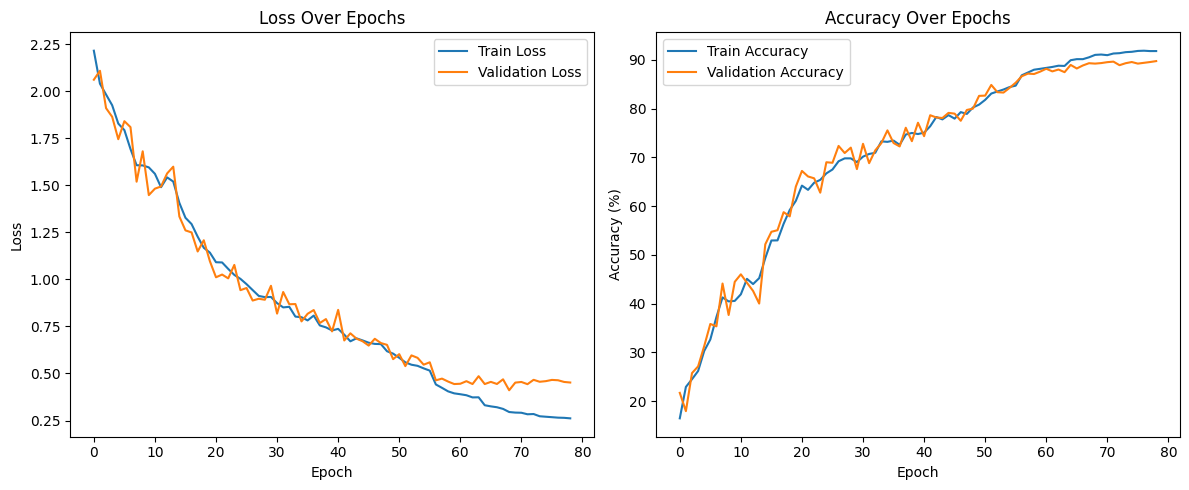

In [ ]:
# Train the model
learning_rate = 0.001
num_epochs = 200
patience = 10
clip_value = 1.0
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

best_val_loss = float('inf')
early_stop_counter = 0

model_save_path = Path('/content/drive/MyDrive/VanillaRNN')
model_save_path.mkdir(parents=True, exist_ok=True)

# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    for mfccs, labels in train_loader:
        mfccs, labels = mfccs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(mfccs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for mfccs, labels in val_loader:
            mfccs, labels = mfccs.to(device), labels.to(device)
            outputs = model(mfccs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total

    avg_val_loss = val_loss / len(val_loader)
    avg_train_loss = running_loss / len(train_loader)

    # Store metrics for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Loss: {avg_val_loss:.4f}, '
          f'Val Accuracy: {val_accuracy:.2f}%')

    # Learning rate scheduling
    scheduler.step(avg_val_loss)

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), model_save_path / 'RNN_3L_128HUs.pth')
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break


# Plot training and validation metrics
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Load the model
model_save_path = Path('/content/drive/MyDrive/VanillaRNN')
model.load_state_dict(torch.load(f'{model_save_path}/RNN_3L_128HUs.pth'))


model.to(device)


# Evaluate the model
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for mfccs, labels in test_loader:
            mfccs, labels = mfccs.to(device), labels.to(device)
            outputs = model(mfccs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

test_accuracy = evaluate_model(model, test_loader, device)
print(f'Model Test Accuracy: {test_accuracy:.2f}%')

Model Test Accuracy: 88.22%
